# Анализ АB теста

Эксперимент проходил с 2023-05-01 по 2023-05-07 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Задача — проанализировать данные АB-теста. 

TO DO:
1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

# 1 Подгрузка данных 

In [27]:
#импорт библиотек
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandahouse as ph
#делает хеш
import hashlib
from scipy import stats
from scipy.stats import mannwhitneyu

In [28]:
#коннект к БД
connection = {
    'host': '***',
    'password': '***',
    'user': '***',
    'database': '***'
}

In [29]:
#запрос к БД
query = '''
SELECT exp_group,
       user_id,
       countIf(action = 'like') likes,
       countIf(action = 'view') views,
       likes/views ctr
FROM simulator_20230520.feed_actions
WHERE time::DATE BETWEEN '2023-05-01' AND '2023-05-07' AND exp_group in [1,2]
GROUP BY exp_group, user_id
'''

In [30]:
# присваивание полученных данных датафрейму
df = ph.read_clickhouse(query, connection=connection)

In [31]:
#чек
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


# 2 Проверка данных

In [32]:
#проверка корректности разбиения на группы
df.groupby('exp_group')['user_id'].count().to_frame().reset_index()

,exp_group,user_id
0,1,10079
1,2,9952


Количество наблюдений сопоставимо

In [33]:
#проверка пересечения пользователей
users_in_two = df.groupby('user_id').agg({'exp_group': 'nunique'}).query('exp_group > 1')
users_in_two.count()

exp_group    0
dtype: int64

Группы изолированы

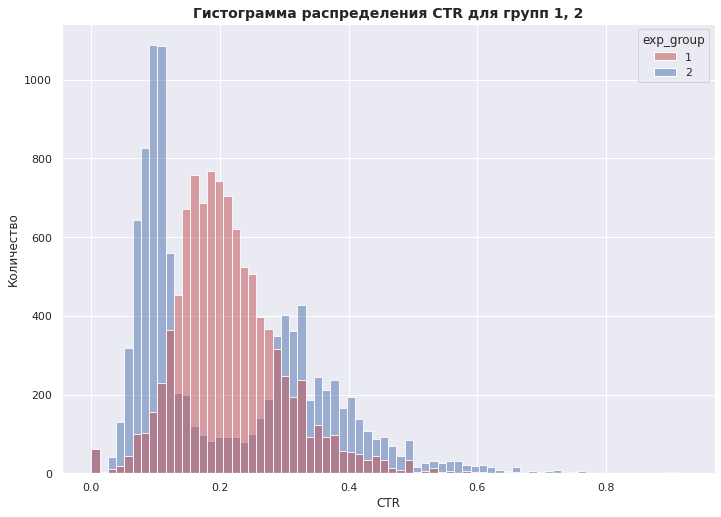

In [34]:
#визуализация распределения ctr в группах
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data =df, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.xlabel('CTR')
plt.ylabel('Количество')
plt.title('Гистограмма распределения CTR для групп 1, 2', fontweight='bold', fontsize=14)
plt.show()

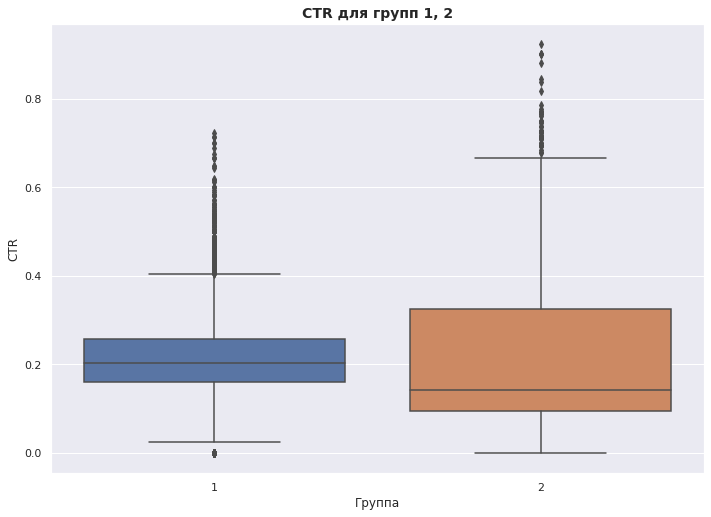

In [35]:
#боксплот
sns.boxplot(x ='exp_group', y='ctr', data=df)
plt.xlabel('Группа')
plt.ylabel('CTR')
plt.title('CTR для групп 1, 2', fontweight='bold', fontsize=14)
plt.show()

Дисперсия группы 2 шире, чем дисперсия группы 1. Распределение ассиметрично. Для группы 1 - распределение похоже на нормальное. 

# 3 Проведение тестов

## t-тест

In [36]:
#средние значения по выборкам
display(df[df.exp_group == 2].ctr.mean())
display(df[df.exp_group == 1].ctr.mean())

0.21441927347479375

0.21560459841296287

In [37]:
#t test 
stat, p = stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 1].ctr, equal_var=False)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05 
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=-0.709, p=0.478
Принимаем нулевую гипотезу: выборки не различаются


Тест показал такие результаты, потому как средние значения показателя довольно близки, но распределения имеют слишком разный характер, поэтому полагаться на данный тест в этом случае неверно.

## тест Манна-Уитни

In [38]:
#тест Манна-Уитни
stat, p = mannwhitneyu(df[df.exp_group == 2].ctr, df[df.exp_group == 1].ctr)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=43704947.500, p=0.000
Отвергаем нулевую гипотезу: выборки различаются


Тест более эффективен за счёт меньшей требовательности к форме распределения.

## сглаживание CTR + t-тест

### функции

In [39]:
#функция для сглаживания
def sm_ctr(likes, views, global_ctr, alpha):
    smm_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smm_ctr

In [40]:
#функция добавления столбца с глобальным CTR
def choose_global(row):
    if row['exp_group'] == 1: 
        return global_ctr_1
    elif row['exp_group'] == 2: 
        return global_ctr_2

### расчёты

In [41]:
#расчёт глобального CTR 
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [42]:
#добавление столбца с глобальным CTR
df['global'] = df.apply(choose_global, axis=1)

In [43]:
#чек
df.head()

,exp_group,user_id,likes,views,ctr,global
0,1,109963,3,15,0.200000,0.208027
1,1,26117,32,141,0.226950,0.208027
2,1,138232,18,73,0.246575,0.208027
3,1,26295,33,122,0.270492,0.208027
4,1,18392,7,32,0.218750,0.208027


In [44]:
#добавление столбца со сглаженным CTR
df['smooth_criminal'] = df.apply(lambda x: sm_ctr(x['likes'], x['views'], x['global'], 5), axis=1) 

In [45]:
#чек
df.head()

,exp_group,user_id,likes,views,ctr,global,smooth_criminal
0,1,109963,3,15,0.200000,0.208027,0.202007
1,1,26117,32,141,0.226950,0.208027,0.226302
2,1,138232,18,73,0.246575,0.208027,0.244104
3,1,26295,33,122,0.270492,0.208027,0.268033
4,1,18392,7,32,0.218750,0.208027,0.217301


### визуализация

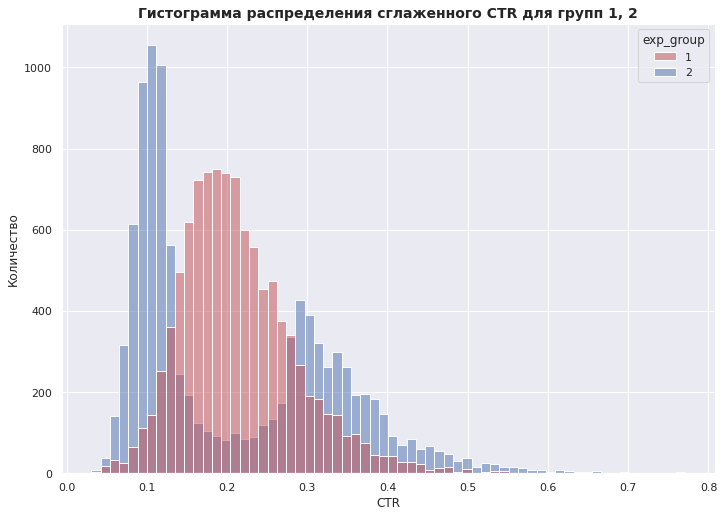

In [46]:
#визуализация распределения сглаженного ctr в группах
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data =df, x='smooth_criminal', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.xlabel('CTR')
plt.ylabel('Количество')
plt.title('Гистограмма распределения сглаженного CTR для групп 1, 2', fontweight='bold', fontsize=14)
plt.show()

In [47]:
#средние значения по выборкам после сглаживания
display(df[df.exp_group == 2].smooth_criminal.mean())
display(df[df.exp_group == 1].smooth_criminal.mean())

0.21073955503259234

0.21402549608884142

После применения сглаживания CTR разница в средних незначительно изменилась.  

In [48]:
#t test по сглаженной метрике
stat, p = stats.ttest_ind(df[df.exp_group == 2].smooth_criminal, df[df.exp_group == 1].smooth_criminal, equal_var=False)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05 
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=-2.284, p=0.022
Отвергаем нулевую гипотезу: выборки различаются


За счёт того, что с помощью сглаживания был убран шум из данных, t-тест показал различия.

## Пуасоновский бутстрэп

In [49]:
#функция бутстрэпа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [51]:
#расчёт значений
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

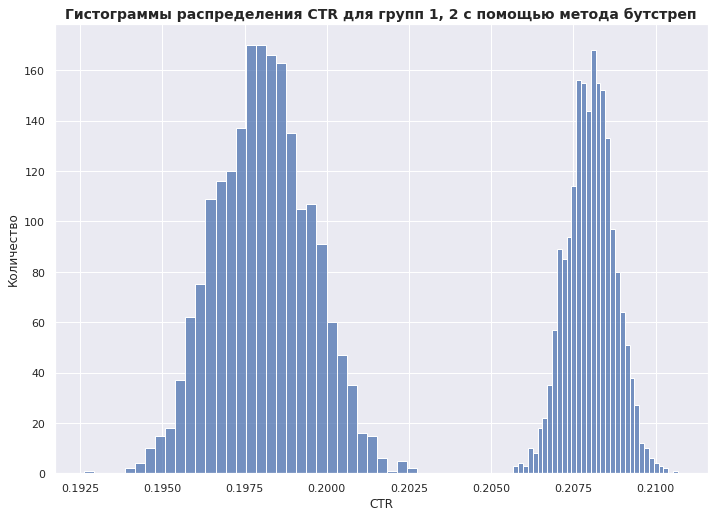

In [25]:
#визуализация
sns.histplot(ctr1)
sns.histplot(ctr2)
plt.xlabel('CTR')
plt.ylabel('Количество')
plt.title('Гистограммы распределения CTR для групп 1, 2 с помощью метода бутстреп', fontweight='bold', fontsize=14)
plt.show()

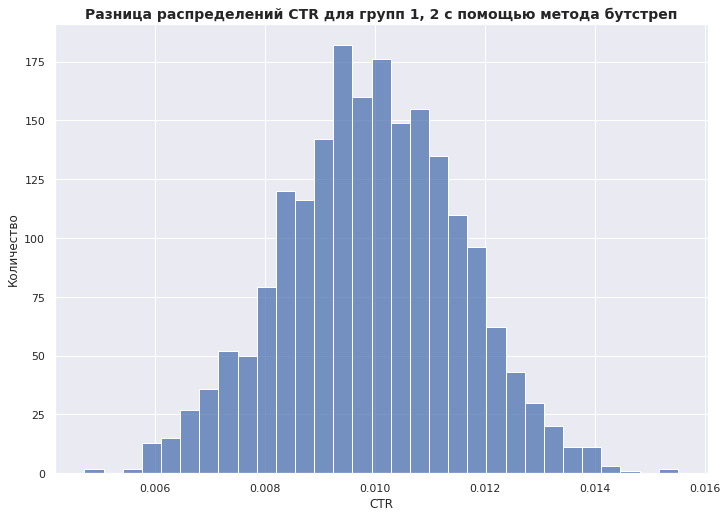

In [26]:
sns.histplot(ctr1 - ctr2)
plt.xlabel('CTR')
plt.ylabel('Количество')
plt.title('Разница распределений CTR для групп 1, 2 с помощью метода бутстреп', fontweight='bold', fontsize=14)
plt.show()

Разница между группами очевидна, в пользу группы 2.

## Бакетное преобразование

### подготовка данных

In [27]:
#функция для разбиения пользователей на бакеты
def bucket_list(id, n_groups=50):
    temp = int(hashlib.md5(str(id).encode('ascii')).hexdigest(), 16)
    return temp % n_groups

In [28]:
#срез датафрейма
df_backet = df[['exp_group', 'user_id', 'likes', 'views', 'ctr']]
df_backet.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [29]:
#разбиение пользователей на бакеты
df_backet = df_backet.copy()
df_backet['backet'] = df_backet['user_id'].apply(bucket_list)

In [33]:
#проверка пересечения пользователей в бакетах
test = df_backet.groupby('user_id').agg({'backet': 'nunique'}).query('backet > 1')
test.count()

backet    0
dtype: int64

In [36]:
#чек
df_backet.head()

,exp_group,user_id,likes,views,ctr,backet
0,1,109963,3,15,0.200000,13
1,1,26117,32,141,0.226950,13
2,1,138232,18,73,0.246575,12
3,1,26295,33,122,0.270492,35
4,1,18392,7,32,0.218750,24


In [46]:
#группировка
df_backet_grouped = df_backet.groupby(['exp_group', 'backet']).agg({'likes': 'sum', 'views': 'sum'}).apply(lambda x: x['likes'] / x['views'], axis=1).to_frame().reset_index()
#переименование колонок
df_backet_grouped.columns = ['exp_group', 'backet', 'ctr_grouped']

In [48]:
#чек
df_backet_grouped.head()

,exp_group,backet,ctr_grouped
0,1,0,0.206220
1,1,1,0.210665
2,1,2,0.207680
3,1,3,0.205832
4,1,4,0.211983


### тесты

In [50]:
#t test 
stat, p = stats.ttest_ind(df_backet_grouped[df_backet_grouped.exp_group == 2].ctr_grouped, df_backet_grouped[df_backet_grouped.exp_group == 1].ctr_grouped, equal_var=False)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05 
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=-5.814, p=0.000
Отвергаем нулевую гипотезу: выборки различаются


In [51]:
#тест Манна-Уитни
stat, p = mannwhitneyu(df_backet_grouped[df_backet_grouped.exp_group == 2].ctr_grouped, df_backet_grouped[df_backet_grouped.exp_group == 1].ctr_grouped)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=529.000, p=0.000
Отвергаем нулевую гипотезу: выборки различаются


Оба теста демонстрируют стат. различия в выборках.

# Выводы

В ходе исследования были проанализированы 2 группы пользователей, для одной из котороы был использован новый алгоритм рекомендаций постов. Были проведены следующие тесты:

- t-тест;
- тест Манна-Уитни;
- t-тест на сгладенном CTR;
- Пуассоновский бутстреп;
- t-тест и тест Манна-Уитни поверх бакетного преобразования.

За счёт неоднородности распределения признака в экспериментальной группе, классический t-test не показал стат. значимого различия, остальные же тесты продемонстрировали различия в выборках. Метод "бутстреп" продемонстрировал явные различия в пользу экспериментальной группы в общегрупповом CTR. С точки зрения исследуемого показателя, значения выше в экспериментальной группе, однако распределение признака неоднородно, что может говорить о разной вовлеченности пользователей в предлагаемый контент. Первый горб распределения CTR соответствует постам, которые получили много показов, но мало лайков, что может говорить о том, что аудитория не считает контент интересным. Второй горб соответствует постам, которые получили много лайков от меньшей части аудитории. Значит эта группа пользователей ощущает связь с предлагаемым контентом. В целом, необходимо оптимизировать алгоритм для более широкой аудитории, следовательно его применение на всех пользователей в настоящий момент, может привести к спаду общей вовлеченности пользователей.   
